In [1]:
import h5py
import psana
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import  rotate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,minimize
import multiprocessing
import os
from functools import partial
import time
import sys
import argparse
from datetime import datetime
import tempfile
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization


<font size=5>XES Analysis and Visualization Test<br>WITH ROTATION</font>

In [2]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='xcs',experiment_id='xcsp23820',lcls_run=21)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
xes.end_index=-1#2000#only import the first 5000 shots
xes.mintime=-2
xes.maxtime=10
xes.numpoints=240
xes.adu_cutoff=[30,999]#3.0
xes.angle=1.3
xes.pixels_to_patch=[225,350,351,352,353,354,355,356,436,437]
xes.key_epix=['epix_1/ROI_0_area']
xes.set_key_aliases(keys=['tt/ttCorr','epics/lxt_ttc', 'enc/lasDelay' , 'ipm4/sum','tt/AMPL','epix_2/ROI_0_area'], names=['time_tool_correction','lxt_ttc'  ,'encoder','ipm', 'time_tool_ampl','epix'])
xes.rois=[[0,-1]]#[[22,30]]
#xes.add_filter('xray','ipm4',1.0E3)
#xes.add_filter('simultaneous','ipm4',1.0E3)
#xes.add_filter('simultaneous','time_tool_ampl',0.15)
xes.run_parser(['211-212'])

In [ ]:
start=time.time()
xes.primary_analysis_parallel_loop(2,xes_experiment)
#xes.primary_analysis_loop(xes_experiment)
end=time.time()

In [ ]:
plt.plot(xes.analyzed_runs[0].delays)

In [ ]:
plt.plot(np.sum(xes.analyzed_runs[0].epix_xray_not_laser_time_binned_ROI_1[:],axis=1))

In [ ]:
plt.plot(np.sum(xes.analyzed_runs[0].epix_simultaneous_laser_time_binned_ROI_1[:],axis=0))
#plt.plot(np.sum(xes.analyzed_runs[0].epix_xray_not_laser_time_binned_ROI_1[:]*6,axis=0))
#plt.axvline(350)
#plt.axvline(356)
#plt.xlim(340,360)

In [7]:
import h5py
fs=h5py.File(r'/sdf/data/lcls/ds/xcs/xcsp23820/hdf5/smalldata/xcsp23820_Run0247.h5')

In [12]:
import numpy as np
epix=np.array(fs['epix_1/ROI_0_area'])[:2000]
epix=epix*(epix>30.0)
epix=epix*(epix<999.0)
epix=np.nansum(epix,axis=0)
#epix=rotate(epix,1.3)

In [13]:
epix

array([[  0.      ,  34.9835  , 227.50471 , ...,  42.28236 ,   0.      ,
        247.69824 ],
       [ 48.232025, 281.97305 , 242.33557 , ...,   0.      ,   0.      ,
         43.952507],
       [  0.      ,  38.892845,   0.      , ...,   0.      , 206.6665  ,
         69.644226],
       ...,
       [  0.      ,  56.403122,  81.89494 , ...,  51.14034 , 160.42416 ,
         41.51893 ],
       [  0.      ,   0.      ,   0.      , ...,  67.01412 ,  57.561165,
         35.906624],
       [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ]], dtype=float32)

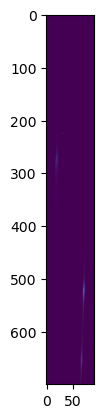

In [14]:
import matplotlib.pyplot as plt
plt.imshow(epix,vmin=0,vmax=100000)

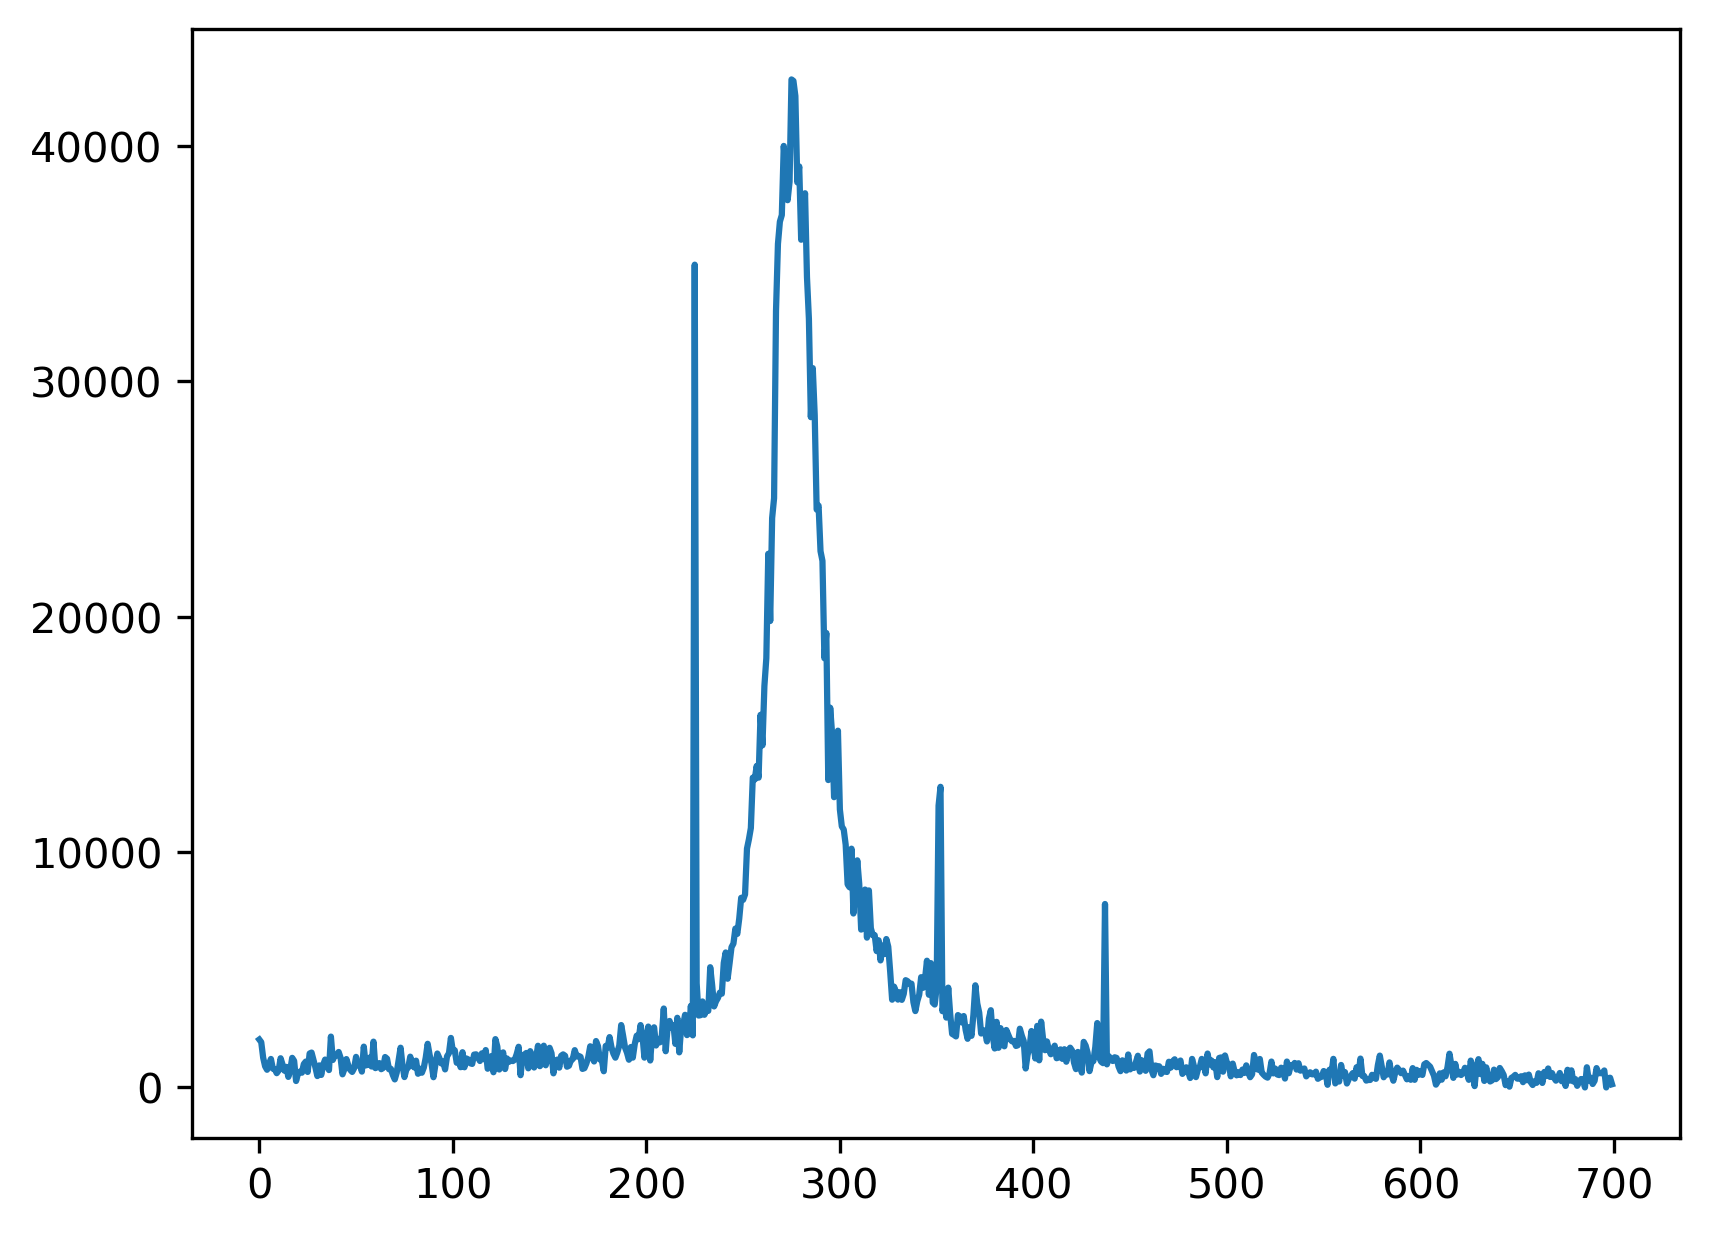

In [15]:
plt.figure(dpi=300)
plt.plot(np.nansum(epix[:,18:35],axis=1))
#plt.plot(np.nansum(epix[:,22:30],axis=1))
#plt.xlim([434,440])

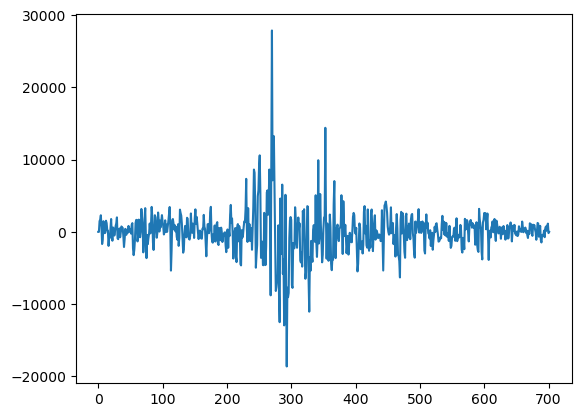

In [22]:
plt.plot(np.sum(xes.analyzed_runs[0].epix_simultaneous_laser_time_binned_ROI_1[:],axis=0)-np.sum(xes.analyzed_runs[0].epix_xray_not_laser_time_binned_ROI_1[:]*6,axis=0))


In [ ]:
plt.plot(np.sum(xes.analyzed_runs[0].epix_simultaneous_laser_time_binned_ROI_1[:],axis=0))
plt.plot(np.sum(xes.analyzed_runs[0].epix_xray_not_laser_time_binned_ROI_1[:]*6,axis=0))

In [24]:
np.shape(xes.analyzed_runs[0].epix_xray_not_laser)

(1131, 702, 106)

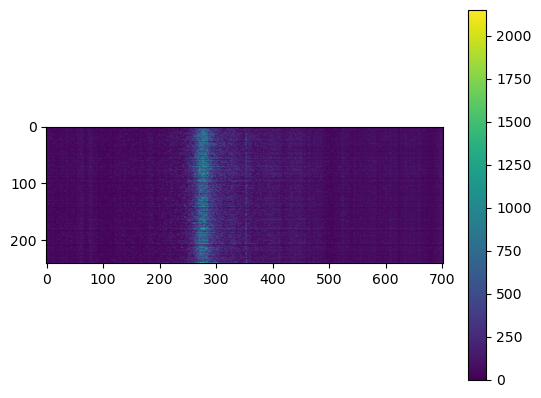

In [12]:
plt.imshow(xes.analyzed_runs[0].epix_simultaneous_laser_time_binned_ROI_1)
plt.colorbar()

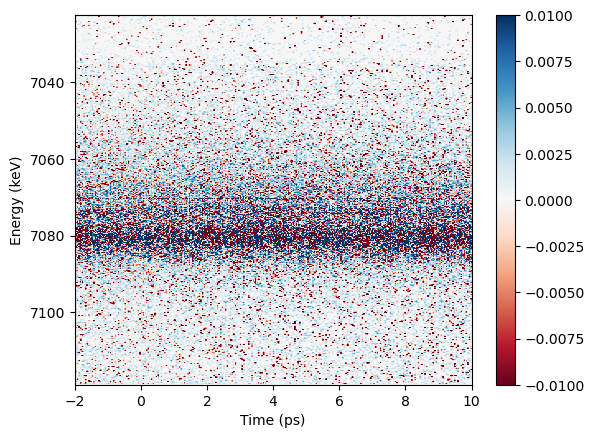

In [7]:
np.shape(xes.analyzed_runs[0].epix_simultaneous_laser_time_binned_ROI_1)
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_spectra(xes_analysis=xes,xes_key='epix_xray_not_laser_time_binned_ROI_1',xes_laser_key='epix_simultaneous_laser_time_binned_ROI_1')
v.vmin=-0.01
v.vmax=0.01
v.plot_2d_difference_spectrum(xes)


In [24]:
import sys

In [28]:
sys.getsizeof(v)

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.

48

In [27]:
import pickle
file_pi = open('test.obj', 'wb') 
pickle.dump(xes, file_pi)

OSError: [Errno 28] No space left on device

In [8]:
for r in xes.analyzed_runs:
    for j,k in zip(r.status_datetime,r.status):
        print(j,k)
        
    print('\n')

2024-02-02 01:24:41 New analysis of run 211 located in: /sdf/data/lcls/ds/xcs/xcsp23820/hdf5/smalldata/xcsp23820_Run0211.h5
2024-02-02 01:24:41 Obtained shot properties
2024-02-02 01:24:41 Key does not exist: Unable to open object (component not found)
2024-02-02 01:24:41 HDF5 import of keys completed. Time: 0.00 seconds
2024-02-02 01:24:41 HDF5 import of keys completed kept as hdf5 dataset. Time: 0.20 seconds
2024-02-02 01:24:41 Detector epix pixel 225 patched.
2024-02-02 01:24:41 Detector epix pixel 351 patched.
2024-02-02 01:24:41 Detector epix pixel 352 patched.
2024-02-02 01:24:41 Detector epix pixel 353 patched.
2024-02-02 01:24:41 Detector epix pixel 354 patched.
2024-02-02 01:24:41 Detector epix pixel 355 patched.
2024-02-02 01:24:41 Detector epix pixel 436 patched.
2024-02-02 01:24:41 Detector epix pixel 437 patched.
2024-02-02 01:24:59 Key: epix has been adu filtered by thresholds: 30.000000,999.000000
2024-02-02 01:24:59 Shots combined for detector epix on filters: simultane

In [10]:
xes.analyzed_runs[3].run_number

214

In [10]:
np.save('XES_Rotation_Time_Domain.npy',xes.difference_spectrum)